##### Please `pip install -r requirements.txt` first

##### Directory Configuration

* `workDir` points to the Git project, holds the *tsv* file
* `libDir` points to Git project subdirectory hosting python library with files names `go.py  stat_utils.py  uniprot.py`
* `dataDir` points to the data folder with uniprot and GO files

In [6]:
import sys, os
workDir = f"{os.getcwd()}/.."
libDir = f"{workDir}/../lib"
dataDir= f"{workDir}/../data" 

sys.path.append(libDir)

In [2]:
import pandas, uniprot, go
import numpy as np

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


In [3]:
workDir

'/Users/guillaumelaunay/work/enseignements/current_content/UCBL/Bioinformatics/M2/_VDB/VDB_jupyter/exercices'

In [10]:
%matplotlib nbagg
import matplotlib.pyplot as plt

## Jeux de données
* Experimental dataset as TSV
* Go ontology as [owl](http://www.obofoundry.org/ontology/go.html)
* Uniprot entries as XML files

## Objectifs
1. Lire et traiter des données d'entrée avec [PANDAS](https://pandas.pydata.org/)

2. Représenter la distribution empirique des "fold-change" (**FC**)
    * Representation d'une grille d'histogrammes
    
3. Evaluer un seuil de **FDR** 5%, avec une approximation par noyau Gaussien de la distribution.
          
4. Analyse de l'enrichissement en pathway Gene Ontology
    1. Arbre des termes d'ontologie.
        * Visualisation de l'arbre complet
    2. Modélisation hypergéometrique des fréquence attendues des termes GO
        * Les protéines très abondantes présentent-elles des termes GO en quantité remarquable ?
        * Les protéines peu abondantes présentent-elles des termes GO en quantité remarquable ?
    3. Visualisation de l'arbre avec style des noeuds rendant compte des protéines qu'ils annotent
 
5. Volcano plot
    1. Scatter-Plot **FC** vs **LOG10 Adj.P-val**
    2. Colorer les protéines très/peu abondantes
    3. ipyWidget slider FDR permettant de changer les seuils "d'abondance" 
    
6. Volcano Plot présentant les pathways
    1. ipyWidget Slider
    2. Coloration des points pour les protéines annotées par ce pathway 

## Conclusion
* Compare wt/mutant conditions


## Ressources
https://www.bioconductor.org/help/course-materials/2015/SeattleApr2015/E_GeneSetEnrichment.html

https://matplotlib.org/gallery.html#




## Format des données expérimentales

Le terme *RA*, désigne le **R**atio d'**A**bondance pour une protéines entre deux experiences.

Les valeurs de **SA** sont stockées dans la colonne ```Log2 Corrected Abundance Ratio```.

Un "ratio" négatif indique qu'une protéine est moins présente dans l'experience considéré par rapport à une experience de référence.

* La condition experimentale de référence est un milieu de croissance bactérienne
* La condition experimentale testée est un milieu riche en Tétracycline 



# Première exploration des données

### Lecture des valeurs experimentales
Charger ```TCL_wt1.tsv``` dans une [dataframe pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html).
* Retirer les lignes présentant des aberrations numériques

##### [Comment filtrer des lignes Pandas](https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/)

In [7]:
### Cellule Exercice

import pandas
import numpy as np

df=pandas.read_csv(workDir + "/TCL_wt1.tsv", delimiter ="\t", na_values="#VALEUR!",
                  dtype= {"Accession": str, "Description" : str, "GeneSymbol": str,
                             "Corrected Abundance ratio (1.53)": np.float64,
                              "Log2 Corrected Abundance Ratio" : np.float64,
                              "Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT)" : np.float64,
                              "LOG10 Adj.P-val" : np.float64
                             }).dropna()
df.head()

,Accession,Description,Gene Symbol,Corrected Abundance ratio (1.53),Log2 Corrected Abundance Ratio,Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT),LOG10 Adj.P-val
0,P75936,Basal-body rod modification protein FlgD OS=Es...,flgD,0.075817,-3.721335,0.000055,4.260067
1,P76231,Uncharacterized protein YeaC OS=Escherichia co...,yeaC,0.092810,-3.429569,0.000351,3.454627
2,P0A8S9,Flagellar transcriptional regulator FlhD OS=Es...,flhD,0.102614,-3.284695,0.000027,4.571899
4,P05706,PTS system glucitol/sorbitol-specific EIIA com...,srlB,0.108497,-3.204277,0.019963,1.699768
5,P29744,Flagellar hook-associated protein 3 OS=Escheri...,flgL,0.124183,-3.009460,0.036746,1.434787


### Visualisation de la distribution empirique

MATPLOTLIB repose sur deux objets principaux:
* [Figure](https://matplotlib.org/stable/api/figure_api.html)
* [AXE](https://matplotlib.org/stable/api/axes_api.html#basic)


Représenter la distribution des **RA** des protéines de l'experience [**Log2 Corrected Abundance Ratio**].
* Réaliser une grille 2x2 avec 4 histogrammes présentant chacun un nombre de catégories différent.
    * Histogramme est une [méthode des objets AXE]
(https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.hist.html#matplotlib.axes.Axes.hist)
    * La taile de la grille est donnée par les paramètres *ncols, nrows*, voir ci dessous
  
`fig1, ( (ax1, ax2), (ax3, ax4) ) = plt.subplots(figsize=(10,6), ncols=2, nrows=2)`

<IPython.core.display.Javascript object>


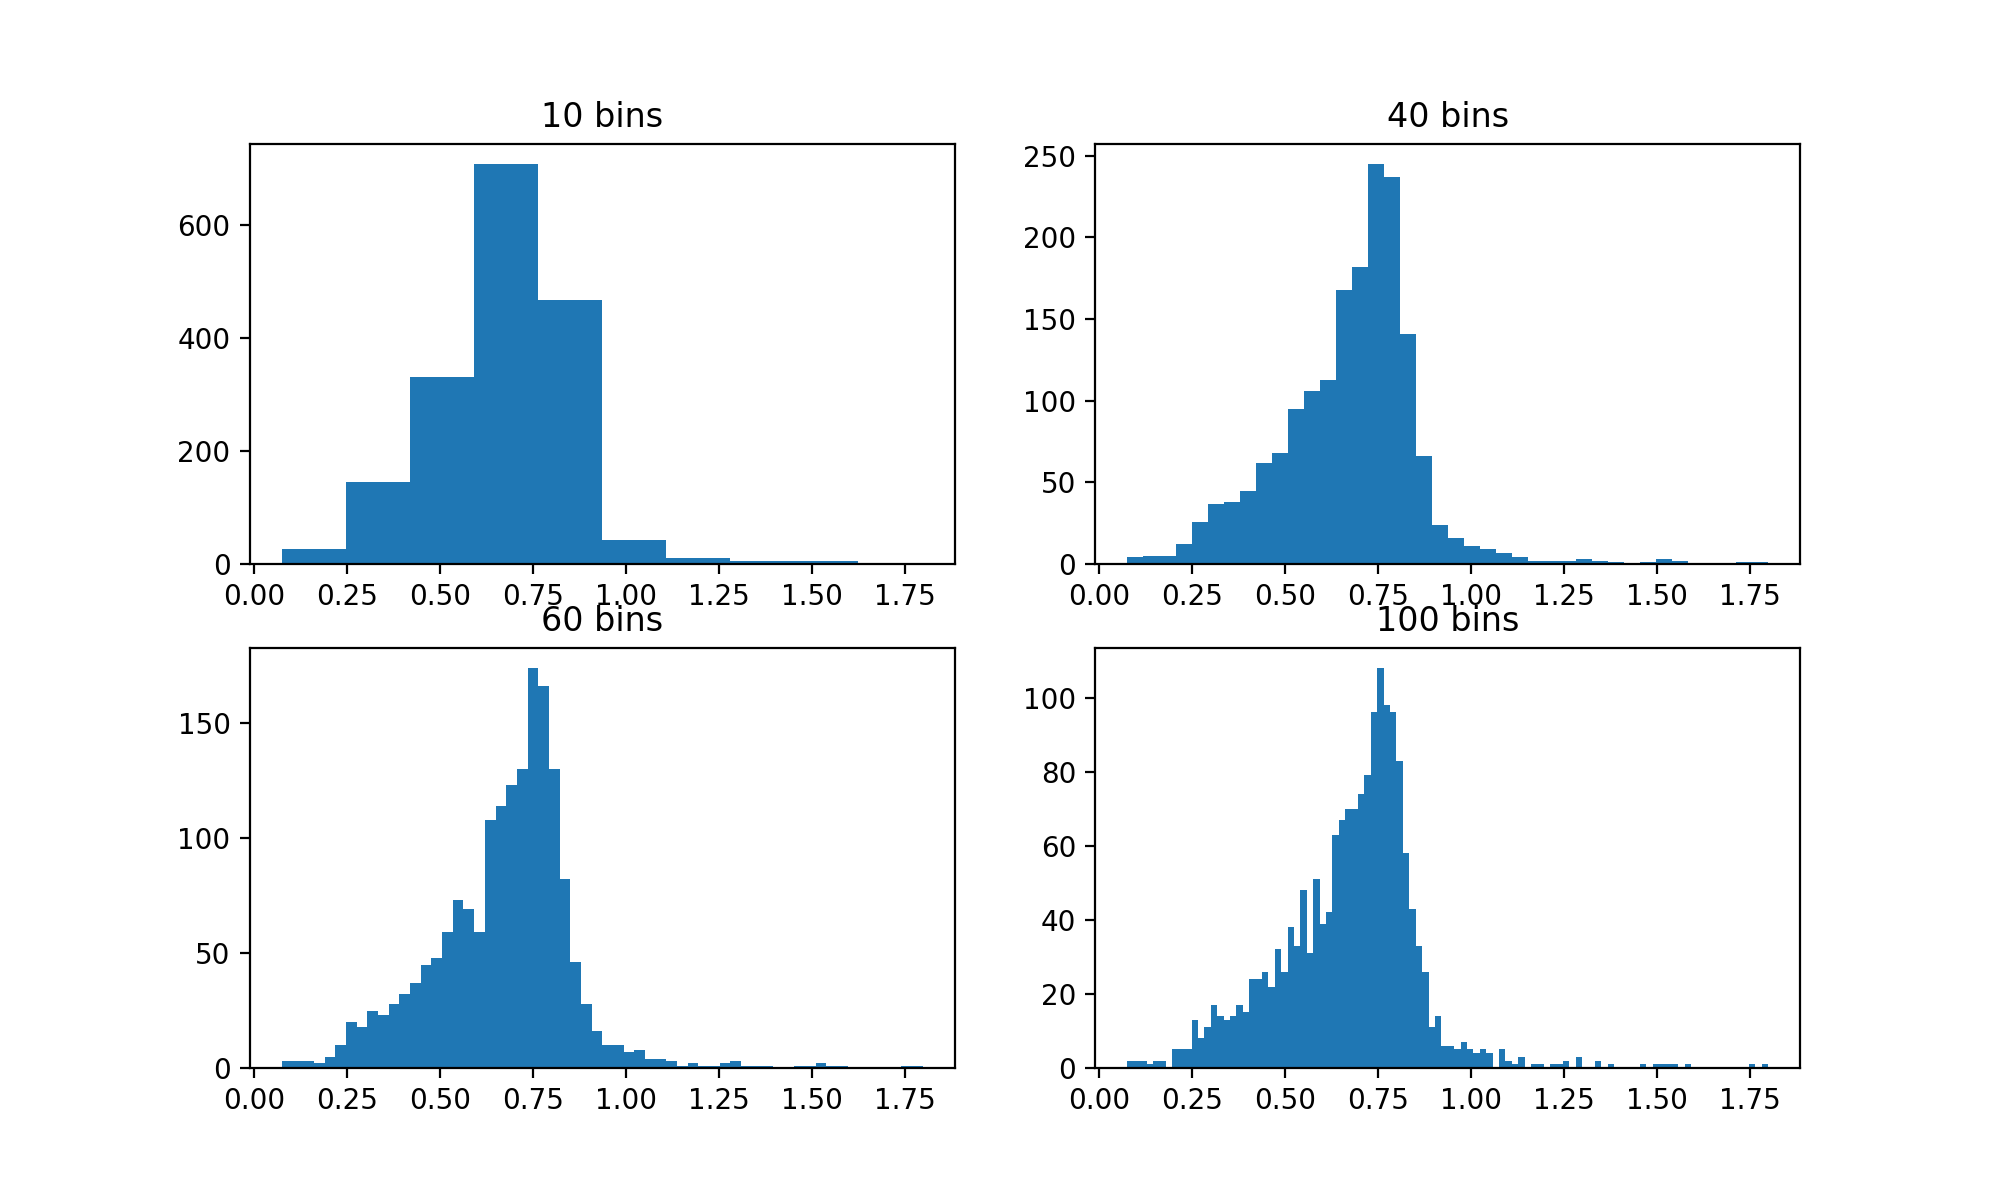

In [69]:
### Cellule Exercice

fig1, f1_axes = plt.subplots(figsize=(10,6), ncols=2, nrows=2)#, constrained_layout=True)
x=df["Corrected Abundance ratio (1.53)"].to_list()
f1_axes[0][0].hist(x, bins=10)
f1_axes[0][0].set_title("10 bins")
f1_axes[0][1].hist(x, bins=40)
f1_axes[0][1].set_title("40 bins")
f1_axes[1][0].hist(x, bins=60)
f1_axes[1][0].set_title("60 bins")
f1_axes[1][1].hist(x, bins=100)
f1_axes[1][1].set_title("100 bins")
fig1.show()

##### Réaliser une Kernel Density Estimation sur un histogramme matplotlib à l'aide du package scipy.
1. En manipulant une représentation déjà produite sur un jeu de données aléatoires
2. En appliquant cette technique au jeu de données expérimentales

In [84]:
from scipy.integrate import quad

alpha=0.245
i_1 = quad(pdf_by_gaussian, alpha, max(s))
i_tot = quad(pdf_by_gaussian, min(s), max(s))
print(i_1[0] / i_tot[0])


0.005170354332959232


###### 1/ Générer 1000 valeurs normalement distribuées.


In [107]:
### mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
print(f"s est un tableau de {len(s)} valeurs normalement distribuées autour de {mu}")
print(f"Les 10 premières valeurs de s sont \n{s[:10]}")

s est un tableau de 1000 valeurs normalement distribuées autour de 0
Les 10 premières valeurs de s sont 
[-0.09844608 -0.02284173 -0.06982396  0.19293453 -0.0532716  -0.04541375
  0.21267908  0.17275268  0.02503749 -0.19108051]


###### 2/ Créer une figure dotée d'un seul "axe"
Dessinons-y l'histogramme des valeurs précedemment générées
* La méthode ax.hist retourne des valeurs !
* Observez les contenus de *count* et *bin*

<IPython.core.display.Javascript object>


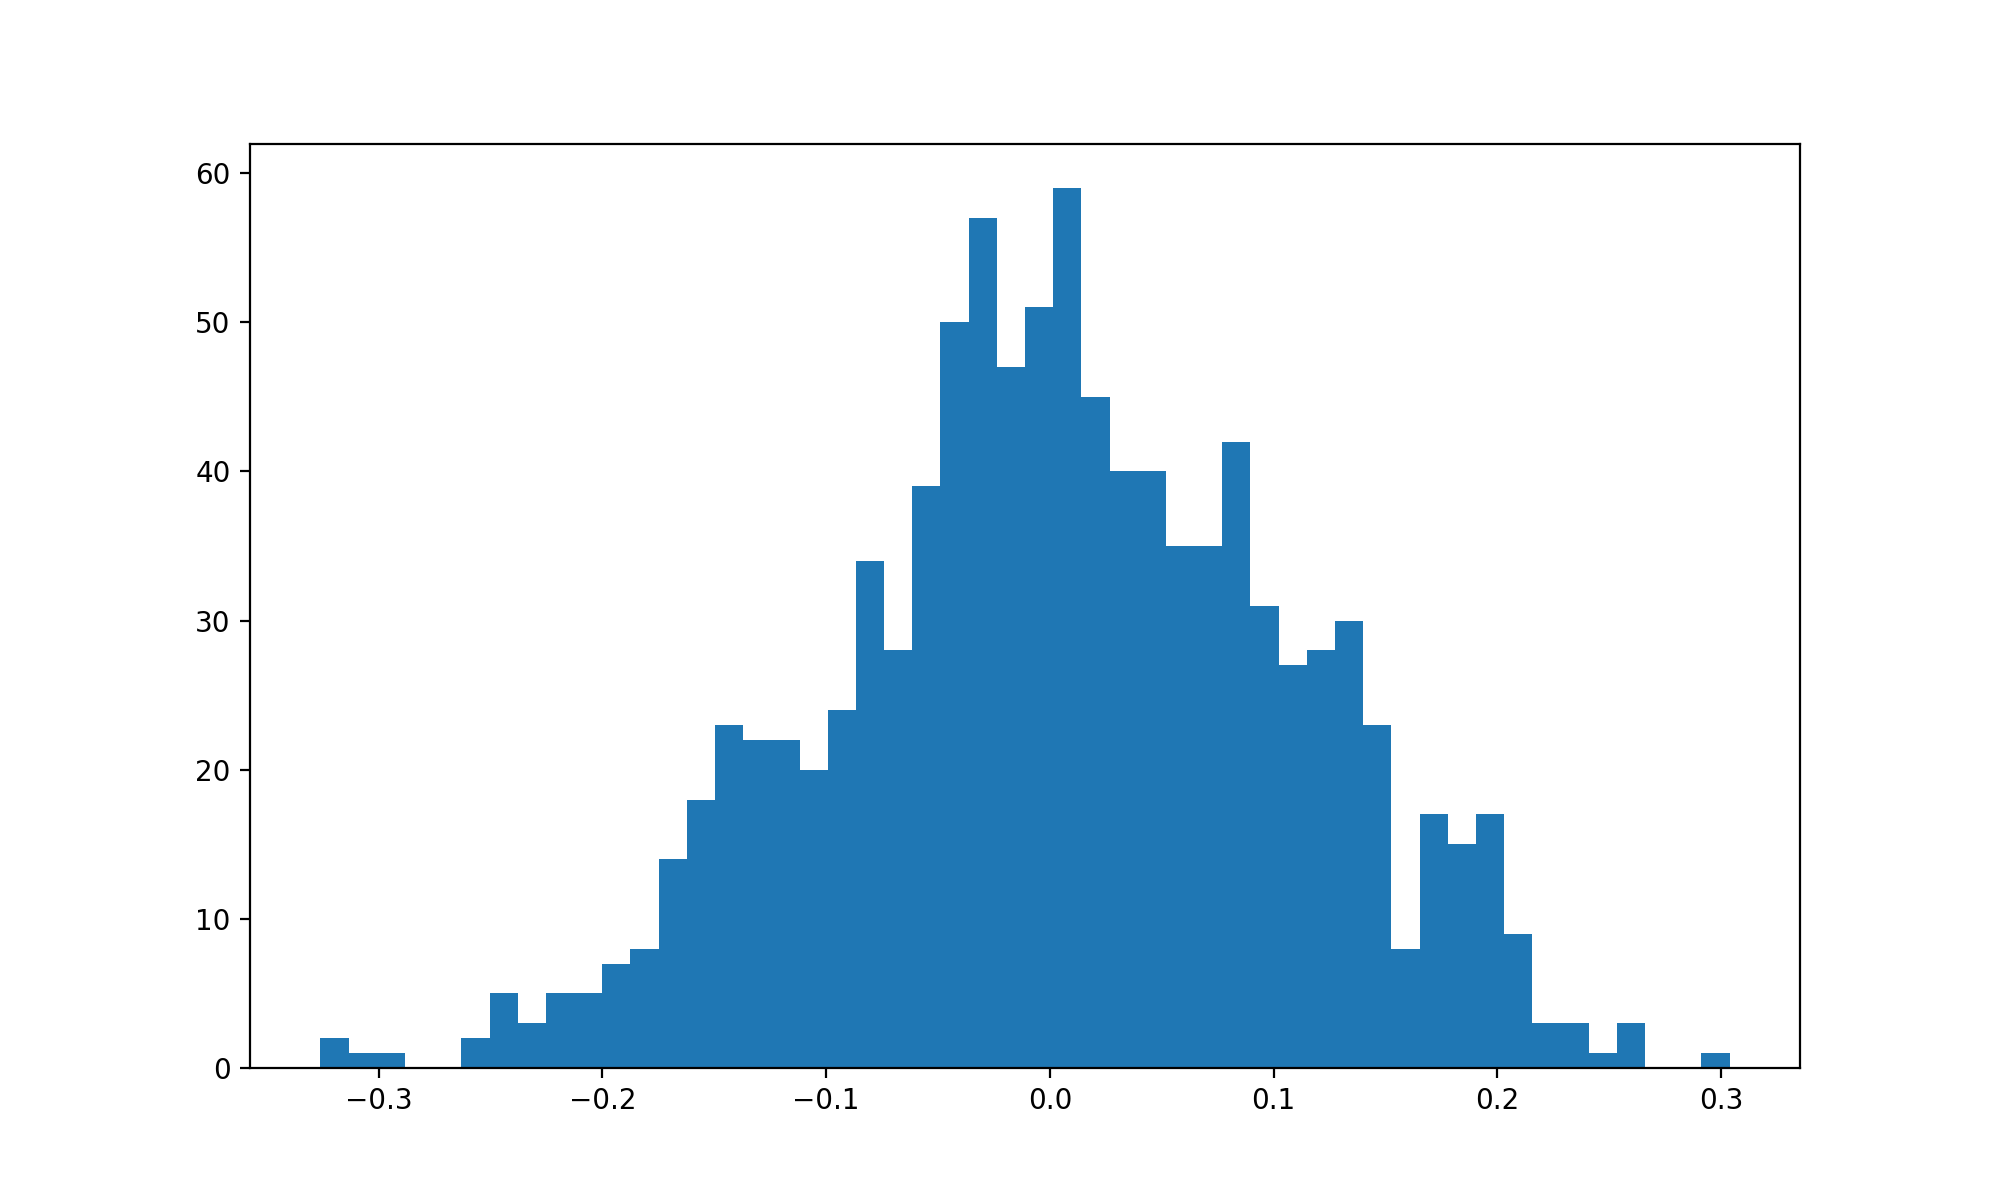

In [108]:
fig2, f2_ax = plt.subplots(figsize=(10,6), ncols=1, nrows=1)#, constrained_layout=True)
count, bins, barObj = f2_ax.hist(s, 50) #, density=True

###### 2/ Estimer la densité de probabilité des 1000 valeurs par noyau Gaussien
Oui c'est bête :D, nous savons que la densité sous-jacente est celle d'une loi normale, mais l'exemple est ainsi assez simple.

In [ ]:
from scipy.stats.kde import gaussian_kde
# Estimation de la densité de probabilité sur le jeu de données ci-dessus par noyau gaussien 
pdf_by_gaussian = gaussian_kde(s)

###### 2(suite)/ Générer la courbe cette densité
* Prenons 1000 points points également répartis entre le minimum et le maximum du jeu de données
* Générons les valeurs correspondantes dans la densité

In [128]:
x_kde = np.linspace(min(s),max(s), 1000)
y_kde = pdf_by_gaussian(x_kde)

#### 3/ Estimation de densité et histogramme

Mettez le paramètre `density` à False sur `count, bins, barObj = f2_ax.hist(s, 50, density=True)`

* Qu'observez-vous ?

* Que contiennent les variables (count, bins) ?

* Combien vaut l'aire sous la courbe et ou sous l'histogramme avec le paramètre density=True ?

* Construisez histogramme et courbe de densité avec les valeurs empirique en ordonnées


<IPython.core.display.Javascript object>


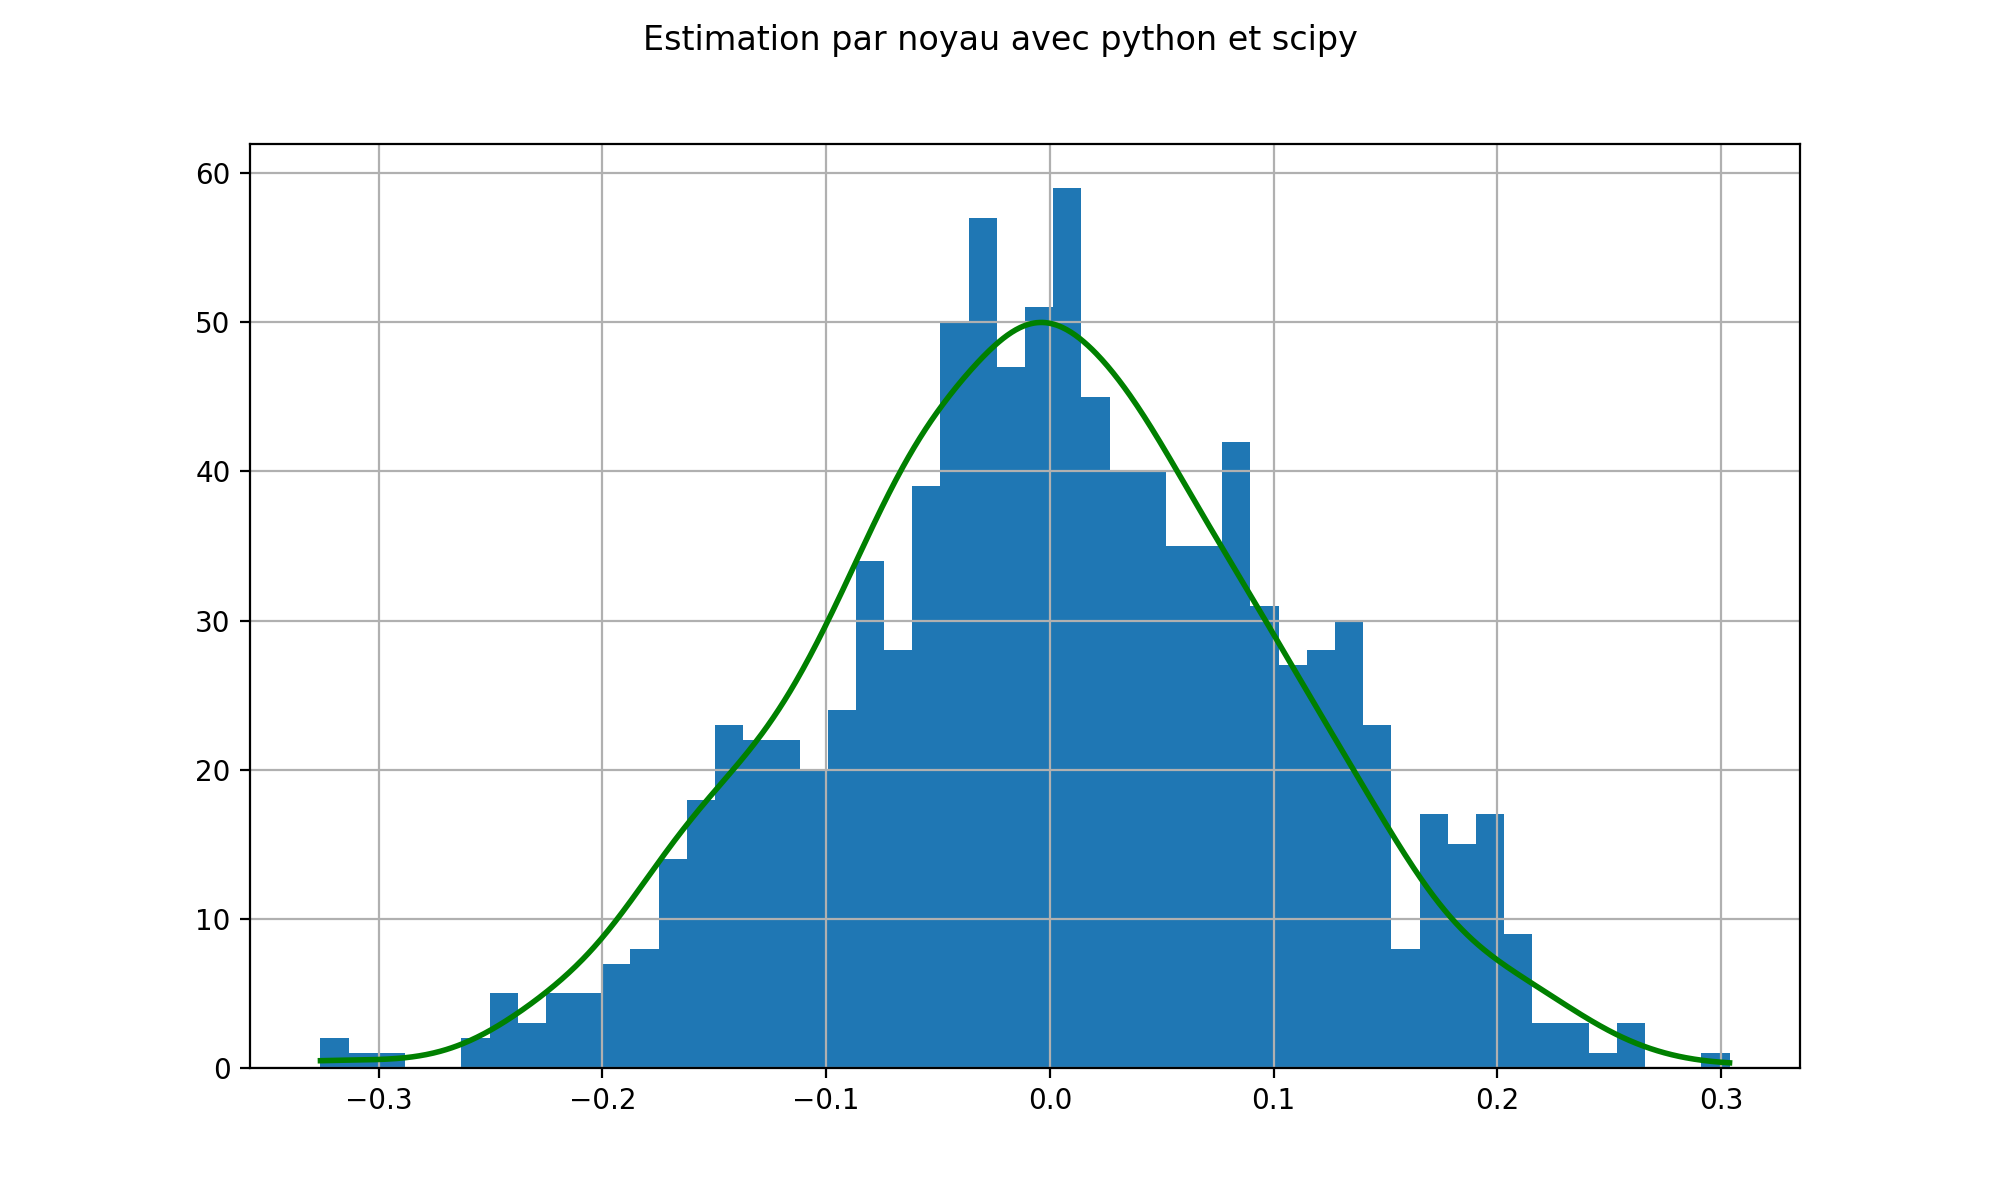

In [131]:
hist_area = 0
for i in range(len(count)):
    hist_area += (bins[i+1] - bins[i]) * count[i]
hist_area



f4, f4_ax = plt.subplots(figsize=(10,6), ncols=1, nrows=1)#, constrained_layout=True)
count, bins, barObj = f4_ax.hist(s, 50) #, density=True

f4_ax.plot(x_kde, y_kde*hist_area, linewidth=2, color='g') 
f4.suptitle("Estimation par noyau avec python et scipy")

f4_ax.grid()

f4.show()

#### 4/ Recherche du seuil alpha

Le package scipy.integrate permet de calculer l'intégrale exacte d'une fonction 

`integral_value, residu = scipy.integrate.quad(f, borne_inf, borne_sup)`

* A l'aide de l'exemple ci-dessus:

    * Calculer la valeur de l'aire sous la courbe de densité estimée entre les valeurs minimale et maximale du jeux de données
    * Chercher la borne d'intégration inférieure **alpha** correspondant "à peu près" à 5% de l'aire totale sous la courbe de la  de densité de probabilité estimée.


In [132]:
from scipy.integrate import quad

alpha=0.245
(integral_value, _) = quad(pdf_by_gaussian, alpha, max(s))
(integral_total, _) = quad(pdf_by_gaussian, min(s), max(s))
print(integral_value / integral_total)


0.005763911619458018


###### 5/ Représentation graphique du seuil alpha
Redessinez le graphique précedent mais avec:
* une ligne verticale rouge matérialisant le seuil **alpha**
* Un [texte](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html) `alpha(5%) = {valeur de alpha}`
* (Bonus) coloriez en rouge [l'aire sous la courbe](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.fill_between.html) de densité correspondant à l'intégrale calculée.

<IPython.core.display.Javascript object>


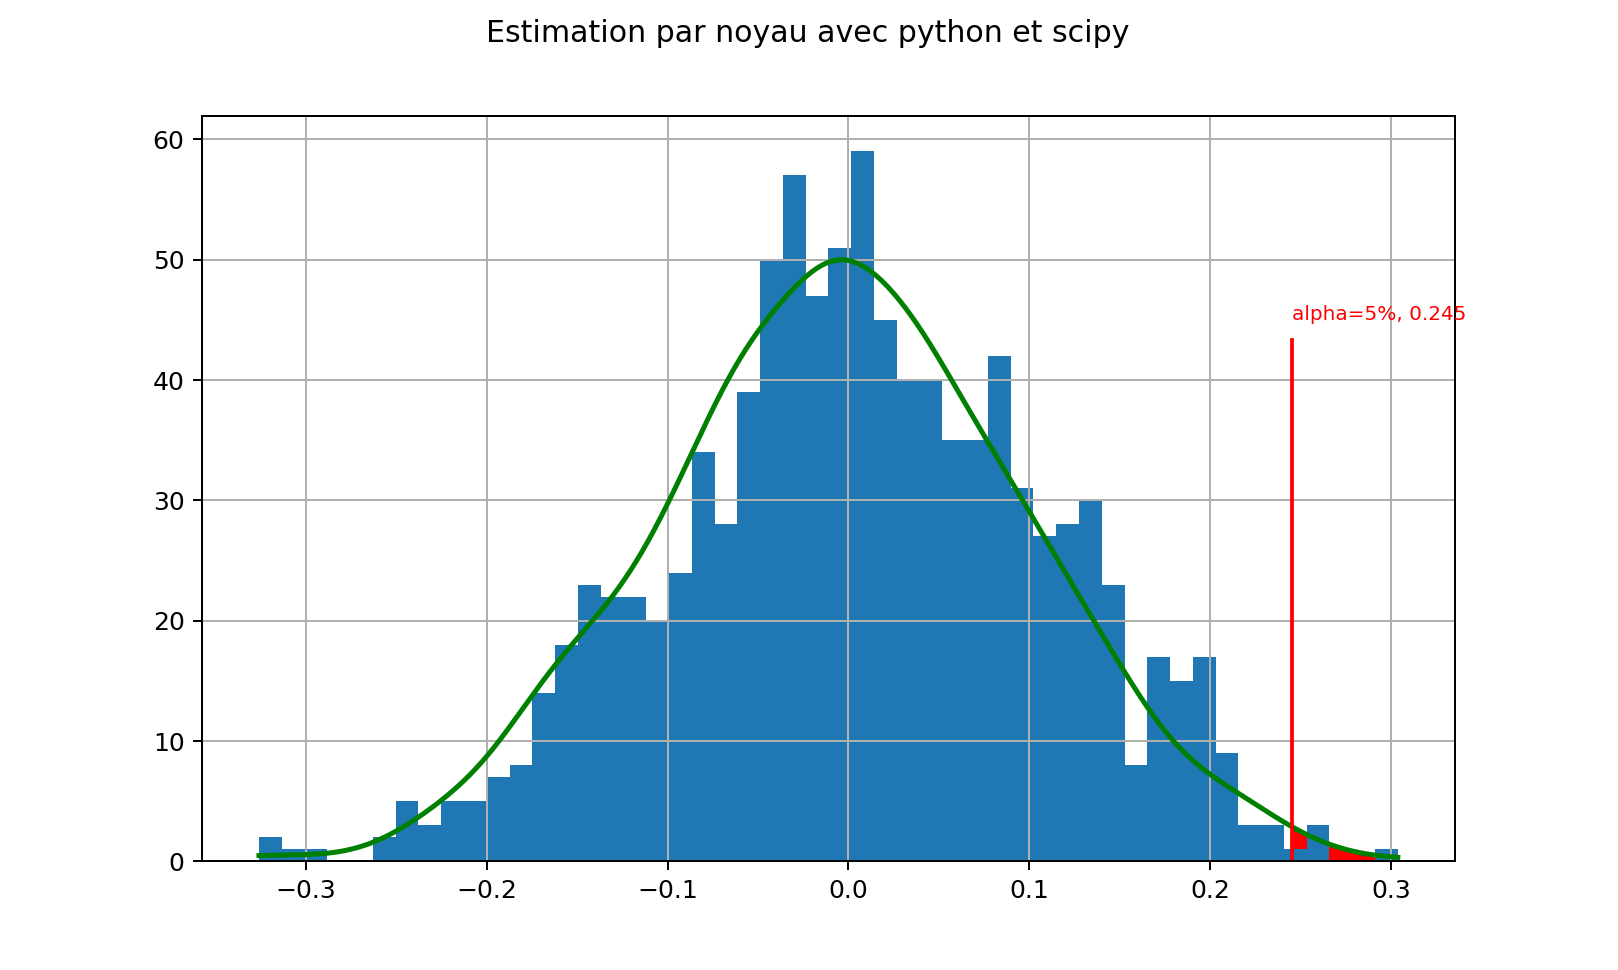

In [143]:
hist_area = 0
for i in range(len(count)):
    hist_area += (bins[i+1] - bins[i]) * count[i]
hist_area



f5, f5_ax = plt.subplots(figsize=(5,3), ncols=1, nrows=1)#, constrained_layout=True)
count, bins, barObj = f5_ax.hist(s, 50) #, density=True

f5_ax.plot(x_kde, y_kde*hist_area, linewidth=2, color='g') 
f5.suptitle("Estimation par noyau avec python et scipy")

f5_ax.grid()


## A FAIRE

f5_ax.axvline(x=alpha, ymin=0, ymax=0.7, color='r')
x_kde_r = np.arange(alpha, max(s), (max(s) - alpha)/100)
y_kde_r = pdf_by_gaussian(x_kde_r)
f5_ax.fill_between(x_kde_r, y_kde_r*hist_area, np.zeros(len(x_kde_r)), color="red")
f5_ax.text(alpha, 45 , f"alpha=5%, {alpha}", fontsize=8,color="red")

f5.show()

## Appliquez cette méthode pour determiner un seuil alpha pour le ratio d'abondance
* Liste de valeurs `Log2 Corrected Abundance Ratio`
1. Estimation de la densité par noyau gaussien 
2. Calcul du seuil alpha
3. Représentation graphique
    * Histogramme
    * Densité 
    * seuil alpha

#### Volcano Plot simple
Ce type de figure représente pour chaque protéine en abscisse le taux d'abondance et en ordonnées la précision de la mesure.
Réaliser les graphiques suivants.
![caption](../figs/volcano_simple.png)

In [ ]:
### Cellule Exercice